In [15]:
# get solar irradiance data 
import requests
import pandas as pd

# Define the API URL
base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"

# Define the query parameters
params = {
    "parameters": "ALLSKY_SFC_SW_DWN",  # Solar irradiance
    "start": "20240707",  # Start date
    "end": "20240713",  # End date
    "latitude": 30.9529,  # Latitude for Balmorhea, Texas
    "longitude": -103.3617,  # Longitude for Balmorhea, Texas
    "community": "re",  # Renewable Energy
    "format": "JSON"  # Response format
}

# Send the GET request
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Extract the solar irradiance data
    solar_data = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
    # Convert to DataFrame
    solar_df = pd.DataFrame(list(solar_data.items()), columns=["Datetime", "Solar_Irradiance"])
    # Parse Datetime values
    solar_df["Datetime"] = pd.to_datetime(solar_df["Datetime"], format="%Y%m%d%H")
    # Convert irradiance to availability
    solar_df["Availability"] = solar_df["Solar_Irradiance"] / solar_df["Solar_Irradiance"].max()
    # Display summary
    print(solar_df)
    # Save to CSV
    solar_df.to_csv("solar_irradiance_balmorhea_july2024.csv", index=False)
else:
    print(f"Error: {response.status_code}")
    print(response.text)


               Datetime  Solar_Irradiance  Availability
0   2024-07-07 00:00:00               0.0           0.0
1   2024-07-07 01:00:00               0.0           0.0
2   2024-07-07 02:00:00               0.0           0.0
3   2024-07-07 03:00:00               0.0           0.0
4   2024-07-07 04:00:00               0.0           0.0
..                  ...               ...           ...
163 2024-07-13 19:00:00               0.0           0.0
164 2024-07-13 20:00:00               0.0           0.0
165 2024-07-13 21:00:00               0.0           0.0
166 2024-07-13 22:00:00               0.0           0.0
167 2024-07-13 23:00:00               0.0           0.0

[168 rows x 3 columns]


In [17]:
import requests
import pandas as pd

# Replace these variables with your specific parameters
base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
parameters = {
    "parameters": "ALLSKY_SFC_SW_DWN",
    "start": "20240707",
    "end": "20240713",
    "latitude": 30.9529,
    "longitude": -103.3617,
    "format": "JSON",
    "community": "re",
}

# Step 1: Fetch data from NASA POWER API
response = requests.get(base_url, params=parameters)
data = response.json()

# Step 2: Parse the data
timestamps = list(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"].keys())
irradiance_values = list(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"].values())

# Step 3: Create a DataFrame
solar_data = {
    "Datetime": pd.to_datetime(timestamps, format="%Y%m%d%H"),  # Convert strings to datetime
    "Solar_Irradiance": irradiance_values,
}
solar_df = pd.DataFrame(solar_data)

# Step 4: Calculate Availability
solar_df["Availability"] = solar_df["Solar_Irradiance"] / max(solar_df["Solar_Irradiance"])

# Step 5: Configure display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 6: Display the DataFrame
print(solar_df)

# Step 7: (Optional) Save to a CSV file
solar_df.to_csv("solar_data_full.csv", index=False)


               Datetime  Solar_Irradiance  Availability
0   2024-07-07 00:00:00              0.00      0.000000
1   2024-07-07 01:00:00              0.00      0.000000
2   2024-07-07 02:00:00              0.00      0.000000
3   2024-07-07 03:00:00              0.00      0.000000
4   2024-07-07 04:00:00              0.00      0.000000
5   2024-07-07 05:00:00             52.53      0.051933
6   2024-07-07 06:00:00            247.25      0.244439
7   2024-07-07 07:00:00            460.20      0.454968
8   2024-07-07 08:00:00            665.08      0.657519
9   2024-07-07 09:00:00            841.60      0.832032
10  2024-07-07 10:00:00            965.15      0.954177
11  2024-07-07 11:00:00            999.65      0.988285
12  2024-07-07 12:00:00            935.35      0.924716
13  2024-07-07 13:00:00            724.05      0.715818
14  2024-07-07 14:00:00            731.17      0.722857
15  2024-07-07 15:00:00            516.12      0.510252
16  2024-07-07 16:00:00            376.50      0

In [19]:
import pandas as pd
import numpy as np
import cvxpy as cp  # used for convex optimisation problems, like this one

#-------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)  # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)  # Have LINE_ID as row index of the dataframe
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)  # 532x1 vector

#-------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}  # indices of generators in node_IDs
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))  # (428,5)
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1  # Mark each generator for each column as a 1

# Demand contributions
demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}  # indices of demands in node_IDs
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))  # (428,20)
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1  # Mark each demand node for each column as a 1

#-------------------------------------------------------------------------------------------------------
# HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
# Load solar irradiance data (output from NASA POWER API processing)
solar_data = pd.read_csv("solar_data_with_availability.csv")  # Replace with the actual filename
solar_availability = np.maximum(solar_data["Availability"].values, 0.2)  # Ensure at least 20% solar capacity

# Generate random wind availability for the example (replace with real wind data if available)
hours = node_demands.shape[0]
wind_availability = np.random.uniform(0.4, 1.0, hours)  # Random wind profile with at least 40% availability

# Create the availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = solar_availability  # Generator 1 (solar)
availability_matrix[1, :] = wind_availability  # Generator 2 (wind)

# Debugging: Check Hourly Availability and Effective Capacity
print("Hourly Solar Availability (Generator 1):", solar_availability)
print("Hourly Wind Availability (Generator 2):", wind_availability)

effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

# Check Total Capacity vs. Demand
total_available_capacity = np.sum(effective_capacity, axis=0)
total_demand = np.sum(node_demands.values.T, axis=0)

print("Total Available Capacity per Hour:", total_available_capacity)
print("Total Demand per Hour:", total_demand)

if any(total_demand > total_available_capacity):
    print("WARNING: Total demand exceeds available generation in some hours!")

# Identify specific problematic hours
for hour, (capacity, demand) in enumerate(zip(total_available_capacity, total_demand)):
    if demand > capacity:
        print(f"Hour {hour}: Demand ({demand:.2f}) exceeds capacity ({capacity:.2f})")

#-------------------------------------------------------------------------------------------------------
# DECISION VARIABLES: q_supply - the power supply from each of the 5 generators for each hour (5x168)
q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply))) 

#-------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# (1) - Total hourly generation must equal the total hourly demand (as assuming no power loss/ have a perfect network)
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))  # axis=0 goes through columns (each hour)

# (2) - Line flow constraints (with maximal power ratings)
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T  # (428x168)
PF = shift_factor_matrix.values @ net_injections

finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None]
]

# (3) - Generator capacity constraints with hourly availability
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]  # Apply availability to capacities

#-------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)  # 5 generator rows by 168 hour columns

# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
    print("Optimal generator dispatch (MW):")
    print(q_supply_table)
else:
    print("NO OPTIMAL SOLUTION FOUND!")


Hourly Solar Availability (Generator 1): [0.2        0.2        0.2        0.2        0.2        0.2
 0.24443895 0.45496787 0.65751854 0.83203164 0.95417696 0.98828473
 0.92471577 0.71581809 0.72285714 0.5102521  0.37221948 0.20471577
 0.2        0.2        0.2        0.2        0.2        0.2
 0.2        0.2        0.2        0.2        0.2        0.2
 0.22251112 0.41193277 0.55541275 0.63017301 0.65394958 0.70074147
 0.64639644 0.62160158 0.71209095 0.58024716 0.40906574 0.20685121
 0.2        0.2        0.2        0.2        0.2        0.2
 0.2        0.2        0.2        0.2        0.2        0.2
 0.22542758 0.43921898 0.63450321 0.80441918 0.90044488 0.86895699
 0.83010381 0.79649036 0.6788433  0.5228868  0.38233317 0.23064755
 0.2        0.2        0.2        0.2        0.2        0.2
 0.2        0.2        0.2        0.2        0.2        0.2
 0.2402175  0.45684627 0.65983193 0.82778052 0.94516065 0.97792388
 0.95709343 0.88584281 0.76930302 0.57076619 0.37829956 0.2
 0.2      

In [1]:
import requests
import pandas as pd

# Define API parameters
url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
params = {
    "parameters": "WS50M",  # Wind Speed at 50 meters
    "start": "20240707",    # Start date
    "end": "20240713",      # End date
    "latitude": 30.9529,    # Latitude for Balmorhea, TX
    "longitude": -103.3617, # Longitude for Balmorhea, TX
    "format": "JSON",
    "community": "re"
}

# Make the API request
response = requests.get(url, params=params)
data = response.json()

# Extract wind speed data
wind_data = data['properties']['parameter']['WS50M']

# Convert to a DataFrame
wind_df = pd.DataFrame(list(wind_data.items()), columns=["Datetime", "Wind_Speed"])
wind_df["Datetime"] = pd.to_datetime(wind_df["Datetime"], format='%Y%m%d%H')

# Display the DataFrame
print(wind_df)


/Users/skyegoodman/Documents/OPTIMISING POWER GRIDS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


               Datetime  Wind_Speed
0   2024-07-07 00:00:00        8.79
1   2024-07-07 01:00:00        8.88
2   2024-07-07 02:00:00        8.46
3   2024-07-07 03:00:00        7.64
4   2024-07-07 04:00:00        6.76
..                  ...         ...
163 2024-07-13 19:00:00        9.15
164 2024-07-13 20:00:00        9.01
165 2024-07-13 21:00:00        9.13
166 2024-07-13 22:00:00        8.98
167 2024-07-13 23:00:00        8.75

[168 rows x 2 columns]


In [2]:
wind_df.to_csv("wind_speed_data.csv", index=False)


In [3]:
# Normalize wind speeds to create availability factors
wind_df["Availability"] = wind_df["Wind_Speed"] / wind_df["Wind_Speed"].max()

# Convert to NumPy array for model integration
wind_availability = wind_df["Availability"].values

# Update the availability matrix
availability_matrix[1, :] = wind_availability  # Assuming Generator 2 is wind

# Debugging: Print wind availability
print("Hourly Wind Availability (Generator 2):", wind_availability)

# Recalculate effective capacity with updated availability
effective_capacity = gen_capacities[:, None] * availability_matrix

# Debugging: Check Effective Capacity
print("Effective Capacity (Generator 1 - Solar):", effective_capacity[0])
print("Effective Capacity (Generator 2 - Wind):", effective_capacity[1])


NameError: name 'availability_matrix' is not defined

In [5]:
import pandas as pd
import numpy as np
import cvxpy as cp # used for convex optimisation problems, like this one

#-------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0) # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0) # Have lINE_ID as row index of the dataframe
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0) # 532x1 vector
#-------------------------------------------------------------------------------------------------------


# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array( generator_data.loc[:, "NODE"].astype(int) )
gen_marginal_costs = np.array( generator_data.loc[:, "MC"] ) # (£/MWh) 
gen_capacities = np.array( generator_data.loc[:, "CAP"] ) # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))


# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}  # indices of generators in node_IDs
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs))) # (428,5)
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1 # Mark each generator for each column as a 1

# Demand contributions
demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}  # indices of demands in node_IDs
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs))) # (428,20)
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1 # Mark each demand node for each column as a 1
#-------------------------------------------------------------------------------------------------------


# DECISION VARIABLES: q_supply - the power supply from each of the 5 generators for each hour (5x168)
q_supply = cp.Variable( (len(gen_IDs), len(node_demands)), nonneg=True) # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
# Elementwise multiplication of cost and power generation for generators for each hour - entries are cost of generator i at time t (i by t matrix)
# Then sum calculates the total cost by summing all entries - this is what needs to be minimised 
# Minimising each hour separately could result in unnecessary fluctuations in generator dispatch - may not meet operational or practical constraints.
objective = cp.Minimize( cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply))) 


# CONSTRAINTS
constraints = []

# (1) - Total hourly generation must equal the total hourly demand (as assuming no power loss/ have a perfect network)
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0)) # axis=0 goes through columns (each hour)
    

# (2) - Line flow constraints (with maximal power ratings)
# Calculate net hourly injections using matrix multiplication. Note negative values for demand rather than generation
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T  # (428x168)

# Compute power flows for all hours using the shift factor matrix
PF = shift_factor_matrix.values @ net_injections

# Add line flow constraints for each line
num_lines = shift_factor_matrix.shape[0]
line_ratings_vector = line_ratings.values.flatten()  # Convert to 1D array

 
finite_mask = np.isfinite(line_ratings_vector) # remove the 'inf' line ratings - only need lines with constraints
constraints += [ # add the constraint that power in line is below its maximal rating 
    PF[finite_mask] <= line_ratings_vector[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings_vector[finite_mask][:, None]
]


# (3) - Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None]] # 5x168 and 5x1 - hourly, check supply value is less than capacity
# Note broadcasting is done to extend gen_capacities for 168 hours - allows for multiplication without using 2 for loops
#-------------------------------------------------------------------------------------------------------


# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)
# This is a linear problem with linear constraints - CBC is quick and can be used
# Other options like Clarabel, SCIPY, ECOS etc. are all compatible with this code if installed - they give same answer


# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)  # 5 generator rows by 168 hour columns

# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
    
    print("Optimal generator dispatch (MW):")
    print(q_supply_table)
else:
    print("NO OPTIMAL SOLUTION FOUND!")

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 22 11:19:46 AM: Your problem has 840 variables, 99456 constraints, and 0 parameters.
(CVXPY) Jan 22 11:19:46 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 11:19:46 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 11:19:46 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 22 11:19:46 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 22 11:19:46 AM: Compiling problem (target solver=CBC).


In [7]:
print("Generator NODE IDs:", generator_data["NODE"].unique())
print("Shift Factor Matrix Column IDs:", shift_factor_matrix.columns.astype(int).values)


Generator NODE IDs: [ 23914  23912 141609 142562  23920]
Shift Factor Matrix Column IDs: [ 11473  11479  11482  11517  11522  11525  11527  11528 140041 140042
 140081 140082 140083 140181 140182 140183 140381 140382 140383 140384
 140401 140402 140403 140441 140442 140443 140471 140472 140473 140501
 140502 140503 140504 140601 140602 140603 140604 140605 140651 140652
 140653 140654 140655 140656 140751 140752 140753 140754 140801 140802
 140803 140804 140805 140851 140852 140853 140854 140855 140856 140857
 140858 140901 140902 140903 140951 140952 140953 140954 140955 140956
 141051 141052 141053 141054 141055 141151 141152 141153 141154 141201
 141202 141203 141204 141205 141206 141207 141301 141302 141303 141351
 141352 141353 141354 141401 141402 141451 141501 141502 141503 141504
 141505 141506 141601 141602 141603 141604 141605 141606 141607 141608
 141609 141711 141712 141713 141714 141761 141762 141763 141764 141765
 141861 141862 141863 141864 141865 141866 141867 141868 14

In [8]:
print("Generator NODE Data Type:", generator_data["NODE"].dtype)
print("Shift Factor Matrix Column Data Type:", shift_factor_matrix.columns.dtype)


Generator NODE Data Type: int64
Shift Factor Matrix Column Data Type: object


In [9]:
missing_nodes = set(generator_data["NODE"]) - set(shift_factor_matrix.columns.astype(int))
print("Missing NODE IDs in Shift Factor Matrix:", missing_nodes)


Missing NODE IDs in Shift Factor Matrix: set()


In [26]:
import pandas as pd
import numpy as np
import cvxpy as cp  # used for convex optimisation problems

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)  # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)  # LINE_ID as row index
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)  # 532x1 vector
# -------------------------------------------------------------------------------------------------------

# Ensure consistent data types for Shift Factor Matrix columns and Generator NODE IDs
shift_factor_matrix.columns = shift_factor_matrix.columns.astype(int)  # Convert to integers
node_IDs = shift_factor_matrix.columns.values
gen_IDs = generator_data["NODE"].values

# # Debug: Verify the data types and content
# print("Shift Factor Matrix Column IDs (after conversion):", node_IDs)
# print("Generator NODE IDs:", gen_IDs)

# -------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)
demand_IDs = np.array(node_demands.columns.astype(int))

# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}  # indices of generators in node_IDs
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

# Demand contributions
demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}  # indices of demands in node_IDs
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES: q_supply - the power supply from each of the 5 generators for each hour (5x168)
q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# CONSTRAINTS
constraints = []

# (1) - Total hourly generation must equal the total hourly demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# (2) - Line flow constraints (with maximal power ratings)
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
line_ratings_vector = line_ratings.values.flatten()
finite_mask = np.isfinite(line_ratings_vector)
constraints += [
    PF[finite_mask] <= line_ratings_vector[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings_vector[finite_mask][:, None],
]

# (3) - Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None]]  # Apply generator capacities

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.ECOS)

# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
    print("Optimal generator dispatch (MW):")
    print(q_supply_table)
else:
    print("NO OPTIMAL SOLUTION FOUND!")


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 22 01:27:24 PM: Your problem has 840 variables, 99456 constraints, and 0 parameters.
(CVXPY) Jan 22 01:27:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 01:27:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 01:27:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 22 01:27:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 22 01:27:24 PM: Compiling problem (target solver=ECOS).

In [28]:
print("Availability Matrix:")
print(availability_matrix)


Availability Matrix:
[[0.         0.         0.         0.         0.         0.05193277
  0.24443895 0.45496787 0.65751854 0.83203164 0.95417696 0.98828473
  0.92471577 0.71581809 0.72285714 0.5102521  0.37221948 0.20471577
  0.03794365 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04391498
  0.22251112 0.41193277 0.55541275 0.63017301 0.65394958 0.70074147
  0.64639644 0.62160158 0.71209095 0.58024716 0.40906574 0.20685121
  0.02706871 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.0405042
  0.22542758 0.43921898 0.63450321 0.80441918 0.90044488 0.86895699
  0.83010381 0.79649036 0.6788433  0.5228868  0.38233317 0.23064755
  0.0397133  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04854177
  0.2402175  0.45684627 0.65983193 0.82778052 0.94516065 0.97792388
  0.95709343 0.88584281 0.76930302 0.57076619 0.3782

In [22]:
effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])


Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          16.98961938  84

In [27]:
import pandas as pd

# Adjust display settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Print the full dispatch results
print("Dispatch for Generator 1 (Solar):")
print(q_supply_table.loc[23914, :])  # Generator 1's row in the q_supply_table

print("\nDispatch for Generator 2 (Wind):")
print(q_supply_table.loc[23912, :])  # Generator 2's row in the q_supply_table



Dispatch for Generator 1 (Solar):
1      255.170396
2      350.000000
3      350.000000
4      350.000000
5      350.000000
6      350.000000
7      350.000000
8      350.000000
9      350.000000
10     350.000000
11     350.000000
12     350.000000
13     350.000000
14     350.000000
15     350.000000
16     350.000000
17     350.000000
18     350.000000
19     350.000000
20     350.000000
21     350.000000
22     350.000000
23     350.000000
24     350.000000
25     350.000000
26     350.000000
27     350.000000
28     350.000000
29     350.000000
30     350.000000
31     350.000000
32     350.000000
33     350.000000
34     350.000000
35     350.000000
36     350.000000
37     350.000000
38     350.000000
39     350.000000
40     350.000000
41     350.000000
42     350.000000
43     350.000000
44     350.000000
45     350.000000
46     350.000000
47     350.000000
48     350.000000
49     350.000000
50     350.000000
51     350.000000
52     350.000000
53     350.000000
54     350.0

In [24]:
binding_hours_solar = np.where(q_supply.value[0, :] == effective_capacity[0, :])[0]
binding_hours_wind = np.where(q_supply.value[1, :] == effective_capacity[1, :])[0]
print(f"Solar Binding Hours: {binding_hours_solar}")
print(f"Wind Binding Hours: {binding_hours_wind}")


Solar Binding Hours: []
Wind Binding Hours: []


In [25]:
max_dispatch_generator_1 = q_supply_table.loc[23914, :].max()
max_capacity_generator_1 = gen_capacities[0] * availability_matrix[0, :].max()
print(f"Max Dispatch (Generator 1): {max_dispatch_generator_1}")
print(f"Max Effective Capacity (Generator 1): {max_capacity_generator_1}")


Max Dispatch (Generator 1): 349.99999999995805
Max Effective Capacity (Generator 1): 350.0


In [29]:
print("Hour | Effective Capacity (Solar) | Dispatch (Solar)")
for hour in range(availability_matrix.shape[1]):
    print(f"{hour+1:4} | {effective_capacity[0, hour]:25.2f} | {q_supply.value[0, hour]:10.2f}")


Hour | Effective Capacity (Solar) | Dispatch (Solar)
   1 |                      0.00 |     255.17
   2 |                      0.00 |     350.00
   3 |                      0.00 |     350.00
   4 |                      0.00 |     350.00
   5 |                      0.00 |     350.00
   6 |                     18.18 |     350.00
   7 |                     85.55 |     350.00
   8 |                    159.24 |     350.00
   9 |                    230.13 |     350.00
  10 |                    291.21 |     350.00
  11 |                    333.96 |     350.00
  12 |                    345.90 |     350.00
  13 |                    323.65 |     350.00
  14 |                    250.54 |     350.00
  15 |                    253.00 |     350.00
  16 |                    178.59 |     350.00
  17 |                    130.28 |     350.00
  18 |                     71.65 |     350.00
  19 |                     13.28 |     350.00
  20 |                      0.00 |     350.00
  21 |                     

In [30]:
total_demand = np.sum(node_demands.values.T, axis=0)  # Sum across nodes for each hour
total_available_capacity = np.sum(effective_capacity, axis=0)  # Total available capacity each hour

print("Hour | Total Demand | Total Available Capacity")
for hour in range(len(total_demand)):
    print(f"{hour+1:4} | {total_demand[hour]:12.2f} | {total_available_capacity[hour]:25.2f}")


Hour | Total Demand | Total Available Capacity
   1 |       468.93 |                    989.76
   2 |       605.96 |                   1100.00
   3 |       595.61 |                   1100.00
   4 |       592.07 |                   1084.42
   5 |       599.63 |                    894.15
   6 |       620.28 |                    912.31
   7 |       644.29 |                    975.55
   8 |       662.50 |                   1259.24
   9 |       688.22 |                   1315.67
  10 |       726.99 |                   1391.21
  11 |       763.65 |                   1223.96
  12 |       780.28 |                   1445.90
  13 |       773.56 |                   1423.65
  14 |       762.20 |                   1171.53
  15 |       753.62 |                   1159.79
  16 |       747.67 |                   1086.13
  17 |       769.87 |                   1091.08
  18 |       830.97 |                   1123.53
  19 |       872.48 |                   1026.49
  20 |       871.62 |                    

In [31]:
binding_hours_solar = np.where(q_supply.value[0, :] == effective_capacity[0, :])[0]
print(f"Binding Hours for Generator 1 (Solar): {binding_hours_solar}")

# Check the margin between dispatch and effective capacity
margin_solar = q_supply.value[0, :] - effective_capacity[0, :]
print("Margin (Dispatch - Effective Capacity) for Solar Generator:")
print(margin_solar)


Binding Hours for Generator 1 (Solar): []
Margin (Dispatch - Effective Capacity) for Solar Generator:
[ 2.55170396e+02  3.50000000e+02  3.50000000e+02  3.50000000e+02
  3.50000000e+02  3.31823529e+02  2.64446367e+02  1.90761246e+02
  1.19868512e+02  5.87889273e+01  1.60380623e+01  4.10034602e+00
  2.63494810e+01  9.94636678e+01  9.70000000e+01  1.71411765e+02
  2.19723183e+02  2.78349481e+02  3.36719723e+02  3.50000000e+02
  3.50000000e+02  3.50000000e+02  3.50000000e+02  3.50000000e+02
  3.50000000e+02  3.50000000e+02  3.50000000e+02  3.50000000e+02
  3.50000000e+02  3.34629758e+02  2.72121107e+02  2.05823529e+02
  1.55605536e+02  1.29439446e+02  1.21117647e+02  1.04740484e+02
  1.23761246e+02  1.32439446e+02  1.00768166e+02  1.46913495e+02
  2.06826990e+02  2.77602076e+02  3.40525952e+02  3.50000000e+02
  3.50000000e+02  3.50000000e+02  3.50000000e+02  3.50000000e+02
  3.50000000e+02  3.50000000e+02  3.50000000e+02  3.50000000e+02
  3.50000000e+02  3.35823529e+02  2.71100346e+02  1.9

In [32]:
print("Availability Constraint (Solar):")
print(gen_capacities[0] * availability_matrix[0, :])  # Print expected upper bounds for Solar
print("Constraint Expression:")
print((q_supply[0, :] <= gen_capacities[0] * availability_matrix[0, :]).value)  # Check if it matches


Availability Constraint (Solar):
[  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          16.98961938  84.

In [33]:
hour = 1  # Select a specific hour to debug
print(f"Hour {hour}:")
print(f"Dispatch (q_supply[0, {hour}]): {q_supply.value[0, hour-1]}")
print(f"Effective Capacity (Solar): {effective_capacity[0, hour-1]}")
print(f"Constraint Satisfied: {q_supply.value[0, hour-1] <= effective_capacity[0, hour-1]}")


Hour 1:
Dispatch (q_supply[0, 1]): 255.17039567636786
Effective Capacity (Solar): 0.0
Constraint Satisfied: False


In [34]:
binding_hours_wind = np.where(q_supply.value[1, :] == effective_capacity[1, :])[0]
print(f"Binding Hours for Generator 2 (Wind): {binding_hours_wind}")


Binding Hours for Generator 2 (Wind): []


In [35]:
for hour in range(q_supply.value.shape[1]):
    dispatch = q_supply.value[1, hour]
    capacity = effective_capacity[1, hour]
    if dispatch > capacity:
        print(f"Hour {hour + 1}: Dispatch ({dispatch:.2f}) exceeds Effective Capacity ({capacity:.2f})")


Hour 5: Dispatch (242.33) exceeds Effective Capacity (144.15)
Hour 6: Dispatch (247.65) exceeds Effective Capacity (144.14)
Hour 7: Dispatch (253.79) exceeds Effective Capacity (140.00)
Hour 11: Dispatch (284.19) exceeds Effective Capacity (140.00)
Hour 14: Dispatch (283.75) exceeds Effective Capacity (170.99)
Hour 15: Dispatch (281.64) exceeds Effective Capacity (156.79)
Hour 16: Dispatch (280.13) exceeds Effective Capacity (157.54)
Hour 17: Dispatch (285.91) exceeds Effective Capacity (210.80)
Hour 20: Dispatch (247.75) exceeds Effective Capacity (205.35)
Hour 22: Dispatch (240.22) exceeds Effective Capacity (140.00)
Hour 23: Dispatch (274.52) exceeds Effective Capacity (205.73)
Hour 24: Dispatch (285.13) exceeds Effective Capacity (236.42)
Hour 25: Dispatch (277.67) exceeds Effective Capacity (273.12)
Hour 27: Dispatch (275.30) exceeds Effective Capacity (165.18)
Hour 30: Dispatch (247.33) exceeds Effective Capacity (140.00)
Hour 32: Dispatch (265.39) exceeds Effective Capacity (151

In [36]:
total_available_capacity = np.sum(effective_capacity, axis=0)
total_dispatch = np.sum(q_supply.value, axis=0)
demand = np.sum(node_demands.values.T, axis=0)

for hour in range(len(demand)):
    if total_dispatch[hour] > total_available_capacity[hour]:
        print(f"Hour {hour + 1}: Total Dispatch ({total_dispatch[hour]:.2f}) exceeds Total Available Capacity ({total_available_capacity[hour]:.2f})")


Hour 43: Total Dispatch (980.02) exceeds Total Available Capacity (899.47)
Hour 45: Total Dispatch (979.73) exceeds Total Available Capacity (941.53)
Hour 67: Total Dispatch (905.07) exceeds Total Available Capacity (903.90)


Ramp rates (MW/hour): {3: array([14.99991163]), 4: array([9.99938364]), 5: array([50.00747873])}
Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0

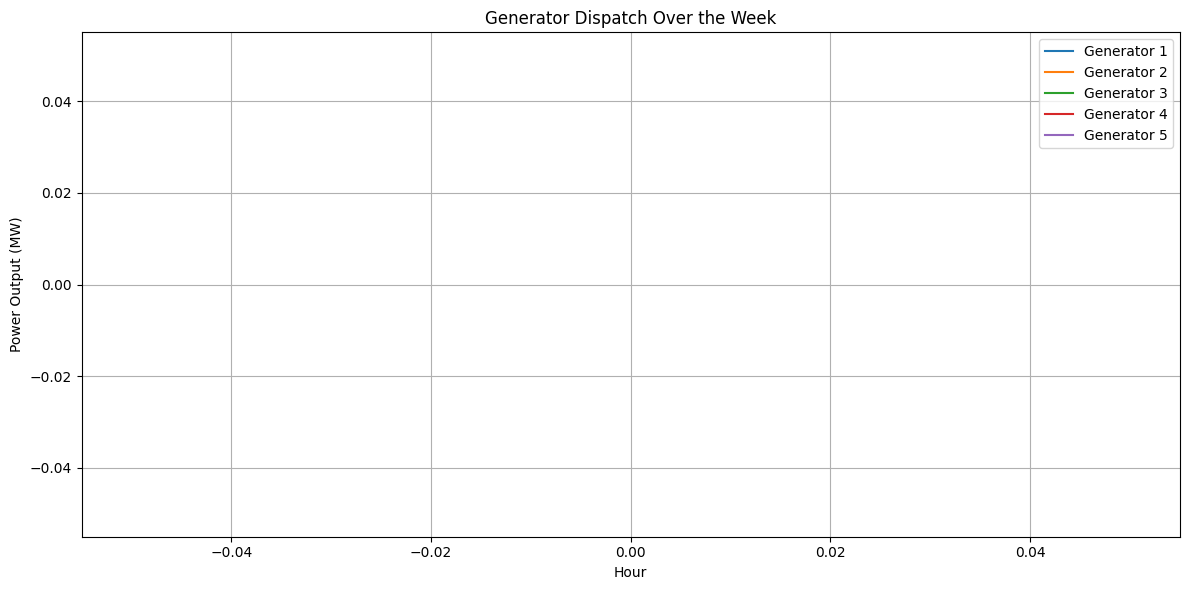

In [38]:
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)  # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)  # PTDF matrix
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)  # Line ratings
# -------------------------------------------------------------------------------------------------------

# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SOLVE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    """
    Simulates a generator's ramping response using a delay differential equation (DDE).
    Args:
        tau: Time constant for the generator.
        delay: Time delay before response begins.
        P_initial: Initial power output (MW).
        P_target: Target power output (MW).
        duration: Total simulation time (hours).
        steps: Number of time steps for simulation.
    Returns:
        ramp_rate: Approximate ramp rate (MW/hour).
    """
    time = np.linspace(0, duration, steps)

    # Define the DDE model
    def model(P, t):
        return (P_target - P(t - delay)) / tau

    # Define the history function
    def history(t):
        return P_initial

    # Solve the DDE
    response = ddeint(model, history, time)

    # Approximate ramp rate as the slope over the simulation period
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)  # Return the absolute value of ramp rate

# Determine ramp rates for generators 3, 4, and 5
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
# Load solar irradiance data (output from NASA POWER API processing)
solar_data = pd.read_csv("solar_data_final.csv")
solar_availability = solar_data["Availability"].values  # Use raw availability values from the data

# Generate Weibull-distributed wind availability
hours = node_demands.shape[0]
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability = np.random.weibull(shape, hours) * scale
wind_availability = np.clip(wind_availability, 0.4, 1.0)  # Ensure at least 40% availability

# Create the availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = solar_availability  # Generator 1 (solar)
availability_matrix[1, :] = wind_availability  # Generator 2 (wind)

# -------------------------------------------------------------------------------------------------------
# CALCULATE EFFECTIVE CAPACITY FOR DEBUGGING
effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES: q_supply - power supply from each generator for each hour (5x168)
q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# (1) - Total hourly generation must equal the total hourly demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# (2) - Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections

finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# (3) - Generator capacity constraints with hourly availability
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# (4) - Ensure remaining demand is met by Generators 3, 4, and 5
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# (5) - Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# (6) - Ramping constraints for Generators 3, 4, and 5
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1  # Adjust for zero-based indexing
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT THE DISPATCH FROM GENERATORS OVER THE WEEK
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
